https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/neumann-poisson/demo_neumann-poisson.py.html

In [49]:
import sys
sys.path.append('/home/memo/')

In [3]:
import Plasmon_Modeling as PM

In [4]:
import matplotlib.pyplot as plt
from dolfin import *

masked_array(
  data=[[-0.39660947647911304, -0.3972444554350547, -0.39826692105588685,
         ..., 0.5966618223209512, 0.6066066224735002, 0.6164083822031289],
        [-0.395574658379578, -0.39592630178617544, -0.3966895016003873,
         ..., 0.5870471477731738, 0.5970154551212133, 0.6068366922413914],
        [-0.3941281421614178, -0.39441346870540006, -0.3948594154962487,
         ..., 0.5776490575391487, 0.587657047226783, 0.5975017915424516],
        ...,
        [-0.39404225727800835, -0.3944032496432498, -0.39495173761870195,
         ..., 0.5775678497228907, 0.5875719392790275, 0.5974159066590423],
        [-0.3954630312657519, -0.39599257122507725, -0.3968722314822421,
         ..., 0.5869339119193262, 0.5968896697705406, 0.6067250651275651],
        [-0.39646363464109097, -0.39713282832122865,
         -0.39818103617247735, ..., 0.5965759374375419,
         0.6064949953596739, 0.6162625403651067]],
  mask=[[False, False, False, ..., False, False, False],
        [False, 

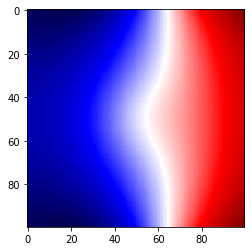

In [7]:
# Create mesh
mesh = UnitSquareMesh.create(64, 64, CellType.Type.triangle)

# Build function space with Lagrange multiplier
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
R = FiniteElement("Real", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, P1 * R)

# Define variational problem
(u, c) = TrialFunction(W)
(v, d) = TestFunctions(W)
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)
g = Expression("-sin(5*x[0])", degree=2)
a = (inner(grad(u), grad(v)) + c*v + u*d)*dx
L = f*v*dx + g*v*ds

# Compute solution
w = Function(W)
solve(a == L, w)
(u, c) = w.split()

PM.process_fenics_function(mesh,u)

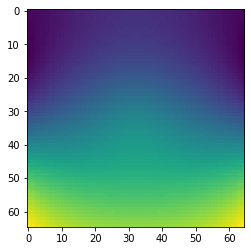

In [8]:
plt.imshow(PM.fenics_func_to_AWA(u,mesh))

## Our Refactor

In [13]:
def uniform_helmholtz(mesh, eigenvalue, number_extracted = 6, sigma_2=1.0, to_plot=False, **kwargs):
    P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R = FiniteElement("Real", mesh.ufl_cell(), 0)
    W = FunctionSpace(mesh, P1 * R)
    V = FunctionSpace(mesh, "Lagrange", 1)

    (u, c) = TrialFunction(W)
    (v, d) = TestFunctions(W)

    Pot = Expression("1", degree=2)

    #define problem
    a = (inner(grad(u), grad(v)) \
         + Pot*u*v + c*v + u*d)*dx
    m = u*v*dx

    A = PETScMatrix()
    M = PETScMatrix()
    _ = PETScVector()
    L = Constant(0.)*v*dx

    assemble_system(a, L, A_tensor=A, b_tensor=_)
    assemble_system(m, L, A_tensor=M, b_tensor=_)

    #create eigensolver
    eigensolver = SLEPcEigenSolver(A,M)
    eigensolver.parameters['spectrum'] = 'target real'
    eigensolver.parameters['tolerance'] = 1.e-15
    eigensolver.parameters["spectral_transform"] = "shift-and-invert"
    eigensolver.parameters["spectral_shift"] = float(eigenvalue) # Could be a possible spot for overflow

    #solve for eigenvalues
    eigensolver.solve(number_extracted)

    assert eigensolver.get_number_converged() > 0

    eigenvalues = []
    eigenfunctions = []

    for i in range(number_extracted):
        u=Function(W)

        r, c, rx, cx = eigensolver.get_eigenpair(i)

        #assign eigenvector to function
        u.vector()[:] = rx
        eigenvalues.append(r)
        a,b = u.split()
        eigenfunctions.append(a)

    #     if to_plot:
    #             plt.figure(); plot(u,interactive=True);plt.title("Eigenvalue: {}".format(r))

    output = dict(list(zip(eigenvalues,eigenfunctions)))
    return output

In [30]:
mesh = UnitSquareMesh.create(64, 64, CellType.Type.triangle)
output = uniform_helmholtz(mesh,5000,number_extracted=5)

In [31]:
processed_eigenvalue_eigenfunction_pairs = dict()

for key, value in output.items():
    processed_eigenvalue_eigenfunction_pairs[key]=PM.fenics_func_to_AWA(value, mesh)

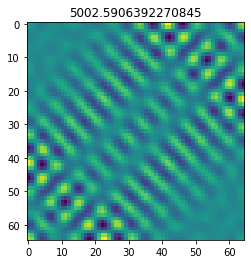

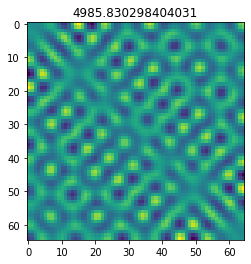

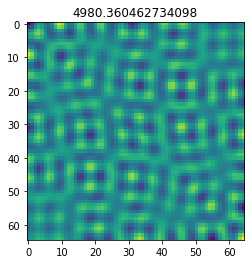

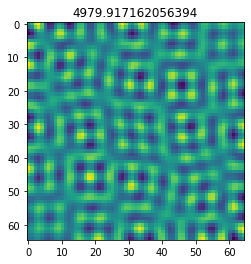

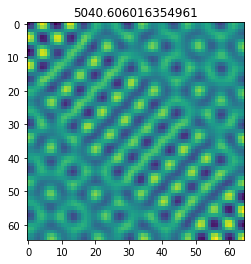

In [32]:
for key, value in processed_eigenvalue_eigenfunction_pairs.items():
    plt.figure();plt.imshow(value);plt.title(key)

https://fenicsproject.org/qa/13481/how-to-convert-a-numpy-array-to-a-vector-in-dolfin/

https://fenicsproject.org/pub/tutorial/html/._ftut1019.html

# Inhomogenous Charge Distribution

In [26]:
def reorder(array,new_order):
    new_array = np.zeros(len(array))
    new_array[new_order]=array
    
    return new_array

def helmholtz(mesh, eigenvalue, number_extracted = 6, sigma_2=1.0, to_plot=False, charge_distribution = lambda x,y: 1, **kwargs):
    P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R = FiniteElement("Real", mesh.ufl_cell(), 0)
    W = FunctionSpace(mesh, P1 * R)
    V = FunctionSpace(mesh, "Lagrange", 1)

    charge_dist_func = Function(V)
    charge = [charge_distribution(coords[0],coords[1]) for coords in mesh.coordinates()]
    charge = reorder(charge,vertex_to_dof_map(V))
    charge_dist_func.vector().set_local(charge)

    (u, c) = TrialFunction(W)
    (v, d) = TestFunctions(W)

    #define problem
    a = (charge_dist_func*inner(grad(u), grad(v)) \
         + u*v + c*v + u*d)*dx
    m = u*v*dx

    A = PETScMatrix()
    M = PETScMatrix()
    _ = PETScVector()
    L = Constant(0.)*v*dx

    assemble_system(a, L, A_tensor=A, b_tensor=_)
    assemble_system(m, L, A_tensor=M, b_tensor=_)

    #create eigensolver
    eigensolver = SLEPcEigenSolver(A,M)
    eigensolver.parameters['spectrum'] = 'target real'
    eigensolver.parameters['tolerance'] = 1.e-15
    eigensolver.parameters["spectral_transform"] = "shift-and-invert"
    eigensolver.parameters["spectral_shift"] = float(eigenvalue) # Could be a possible spot for overflow

    #solve for eigenvalues
    eigensolver.solve(number_extracted)

    assert eigensolver.get_number_converged() > 0

    eigenvalues = []
    eigenfunctions = []

    for i in range(number_extracted):
        u=Function(W)

        r, c, rx, cx = eigensolver.get_eigenpair(i)

        #assign eigenvector to function
        u.vector()[:] = rx
        eigenvalues.append(r)
        a,b = u.split()
        eigenfunctions.append(a)

    #     if to_plot:
    #             plt.figure(); plot(u,interactive=True);plt.title("Eigenvalue: {}".format(r))

    output = dict(list(zip(eigenvalues,eigenfunctions)))
    return output

# Uniform Charge Distribution

In [33]:
mesh = UnitSquareMesh.create(64, 64, CellType.Type.triangle)
output = helmholtz(mesh, 5000, number_extracted = 5)

In [35]:
#Getting eigenvalue eigenfunction pairs and storing it in a dictionary
processed_eigenvalue_eigenfunction_pairs = dict()

for key, value in output.items():
    processed_eigenvalue_eigenfunction_pairs[key]=PM.fenics_func_to_AWA(value, mesh)

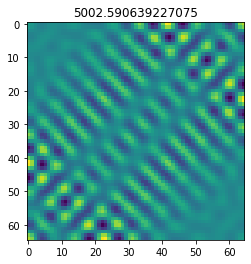

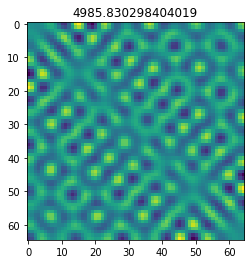

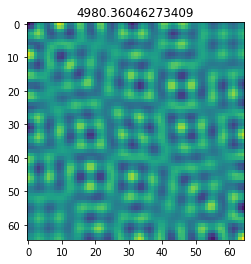

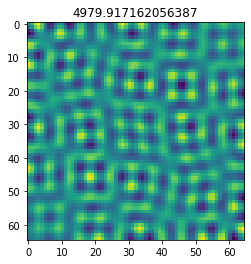

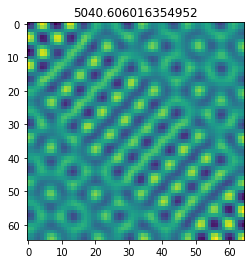

In [36]:
for key, value in processed_eigenvalue_eigenfunction_pairs.items():
    plt.figure();plt.imshow(value);plt.title(key)

# Non Uniform Charge Distribution

## New Charge Distribution

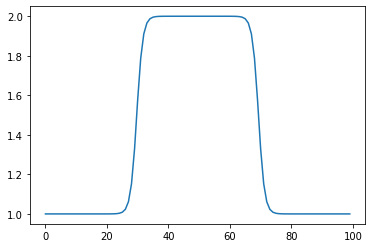

In [43]:
from matplotlib.pyplot import *
from numpy import *
x_axis=np.linspace(0,1,100)
y_axis=np.linspace(0,1,100)

r0=.2; dr=.02
charge_distribution = lambda x,y: 1.5-.5*np.tanh((sqrt((x-0.5)**2+(y-0.5)**2)-r0)/dr)
figure();plot(charge_distribution(linspace(0,1,100),.5))

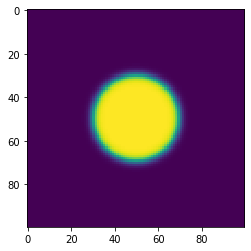

In [45]:
# Charge distribution over x,y in [0,1]
xx,yy = np.meshgrid(x_axis,y_axis)
plt.imshow(charge_distribution(xx,yy))

In [46]:
output = helmholtz(mesh, 5000, number_extracted = 5,charge_distribution=charge_distribution)

In [47]:
#Getting eigenvalue eigenfunction pairs and storing it in a dictionary
processed_eigenvalue_eigenfunction_pairs = dict()

for key, value in output.items():
    processed_eigenvalue_eigenfunction_pairs[key]=PM.fenics_func_to_AWA(value, mesh)

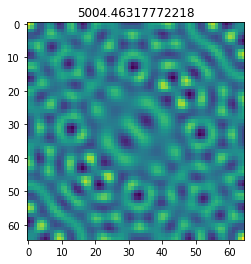

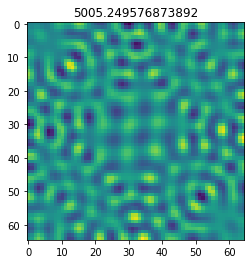

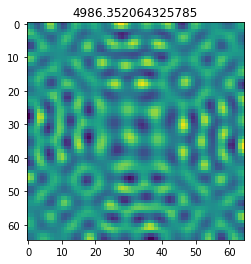

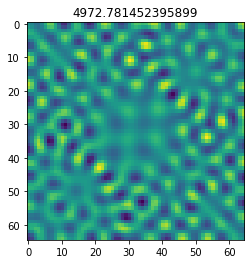

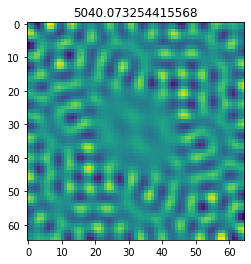

In [48]:
for key, value in processed_eigenvalue_eigenfunction_pairs.items():
    plt.figure();plt.imshow(value);plt.title(key)